In [45]:
import os   #used for directory work
import matplotlib.patches as mpatches #used for plot legends
import matplotlib.pyplot as plt #used for creating plots
import matplotlib.cm as cm
import pandas as pd
import numpy as np
%matplotlib inline

In [46]:
burn_d = {'01': [21000 ,22289], '02': [14000, 14972], '03': [20000, 20296], '04': [30000, 34979], '05': [15000, 15974], \
          '06': [6000, 6544], '07': [25000, 27822], '08': [18000, 19810], '09': [20000, 25047], '11': [30000,30681],  \
          '12': [60000, 62937], '13': [50000, 55131], '18': [185000, 192322], '19': [45000, 48831], '20': [24000, 25860],\
          '21': [25000, 27822], '22': [27000, 29484], '23': [45000, 48846], '24': [20000, 23015], '25': [25000, 26797], \
          '26': [25000, 26909], '27': [35000, 36916], '28': [27000, 28673], '29': [25000, 28166], '30': [12000, 13954], \
          '31': [30000, 31046], '32': [25000, 26294], '33': [20000, 23293], '34': [40000,43702]}

In [3]:
path_02="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-07/sonics/" #79 location
path = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-07/thermal_couples/"

#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Full-Timestamp/Burn-07/thermal_couples/"  #134 location
#path_02 = "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Full-Timestamp/Burn-07/sonics/"

#path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-07/thermal_couples/"
#path_02 = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-07/sonics/"

In [88]:
def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    
    return txt_files

def file_to_df(path):
    df= pd.read_csv(path,na_values = ['NAN', "00nan","000nan","NaN"], sep=" ")
    
    return df

def fire(df,n, x_fire, index_time):    
    ### Finding the start of fire
    sig_lst, e_fire = [], x_fire+index_time
    fire_5sig =  np.nanmean(df["T"][:n])+5*np.std(df["T"][:n]) 
    for i in range(n,len(df["T"])):
        if df["T"][i] > fire_5sig:
            sig_lst.append(i)
    if len(sig_lst)!=0:
        x_fire = np.nanmin(sig_lst)
        e_fire = np.nanmax(sig_lst)        
    
    return x_fire, e_fire


In [122]:
def speed_fun(df):
    speed = list(np.full(len(df),np.nan))
    for i in range(len(df)):
        speed[i] = np.sqrt((df["V"][i]**2) +(df["U"][i]**2))
    return speed

def plotting_S_W(burn,n,x_fire, y_lim= False, index_time = 9000):
    path = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-" #79
    #path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-" #W10
    cols= ['TIMESTAMP', 'TC 0cm', 'TC 5cm', 'TC 10cm', 'TC 20cm',\
                  'TC 30cm', 'TC 50cm', 'TC 100cm']

    tc_files = text_finder(path+burn+"/thermal_couples/")
    sonic_files = text_finder(path+burn+"/sonics/")[4:12]
    
    purp_patch = mpatches.Patch(color = "indigo", label = "S", linewidth = .1)
    pink_patch = mpatches.Patch(color="deeppink", label = "W", linewidth = .1)
    
    colors = ["navy","cyan", "springgreen",\
             "darkkhaki", "orange", "saddlebrown", "firebrick"]
    plot_cols = cols[1:]
    fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(18,8))

    x=0
    for col in range(2):
        for row in range(4):
            df_tc=file_to_df(path+burn+"/thermal_couples/"+tc_files[x])
            df_tc.columns = cols
            df_s = file_to_df(path+burn+"/sonics/"+sonic_files[x])
            speed = speed_fun(df_s)
            
            ### Averaging index
            s_fire, e_fire = fire(df_s, n, x_fire, index_time)
            #30mins = 18000 15mins = 9000 10mins = 6000 5mins = 3000
            
            t_start, t_end = 0,  (len(df_s)-1)
            if s_fire - index_time > 0:
                t_start = s_fire - index_time
            if s_fire + index_time > t_end:
                t_end = s_fire + index_time
            
            ax = axs[ col, row]
            ax.grid()

            x_lst= np.arange(0,len(df_tc)/10,step = .1)
            for i in range(len(plot_cols)):
                ax.scatter(x_lst[t_start:t_end] ,df_tc[plot_cols[i]][t_start:t_end] , label = plot_cols[i], marker = "s", s = .1, c = colors[i], alpha = .5)
            ax.scatter(x_lst[t_start:t_end] ,df_s["T"][t_start:t_end] , label ="Sonic (2.5m)", c = "black", marker = "o", s=.1, alpha = .5)
            ax.vlines((s_fire)/10,-10,600,linestyle = "--",linewidth = .5, label = "Fire Start", color = "r")
            ax.vlines((e_fire)/10,-10,600,linestyle = "--",linewidth = .5, label = "End FFP", color = "b")
            ax.set_xlim(t_start/10, (t_start/10)+(index_time/10)*2)
            
            if y_lim == True:
                ax.set_ylim(0,150)
            if y_lim == False:
                ax.set_ylim(0,600)
            #ax.set_xticks(m_loc)
            #ax.set_xticklabels(markers, rotation = 20, fontsize = 8)
            ax.set_title(tc_files[x][:2], fontsize = 16,fontweight = "bold")
            ax.text(((t_start/10)+(index_time/10)*2-500),152, "-- "+df_tc["TIMESTAMP"][s_fire][11:21], color = "r")
            if row == 0:
                ax.set_ylabel(r"Temperature ($^{\circ}C$)", fontsize = 14)
            if col == 1:
                ax.set_xlabel(r"Time (${s}$)", fontsize = 14)
            
            ax2 = ax.twinx()
            ax2.plot(x_lst[t_start:t_end] , speed[t_start:t_end] , color = "indigo",linewidth =.05, linestyle = "--")
            ax2.plot(x_lst[t_start:t_end] , df_s["W"][t_start:t_end] , c="deeppink", linewidth =.05, linestyle = "--")
            ax2.set_ylim(-6,6)
            if row ==3:
                ax2.set_ylabel(r"Wind Speed ($\frac{m}{s}$)", fontsize = 14)
            
            x=x+1 #used to change the files
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.2, top=.85)#, left = 0.05, right = .95, bottom = .07)
    fig.suptitle("Burn "+burn+"  "+df_tc["TIMESTAMP"][0][:10], fontsize = 20, x= .2, y= .95, fontweight = "bold")
    handles, labels = ax.get_legend_handles_labels()
    
    leg = fig.legend(list(handles[:10]+ [pink_patch, purp_patch]), list(labels[:10]+[ "W", "S"]), ncol = 6, fontsize = 14, bbox_to_anchor=(.9, .99), framealpha = .8,markerscale = 22 )
    [lh.set_alpha(1) for lh in leg.legendHandles ]
    
    if y_lim == True:
        fig.savefig("TEST_W-S-TC-Sonic-Temp-150C-Burn-"+burn+"_Grid.png",dpi=350)
    if y_lim == False:
        fig.savefig("TEST_W-S-TC-Sonic-Temp-Burn-"+burn+"_Grid.png",dpi=350)
    #fig.savefig("Test"+burn+"_Grid.png",dpi=400)
    plt.show()

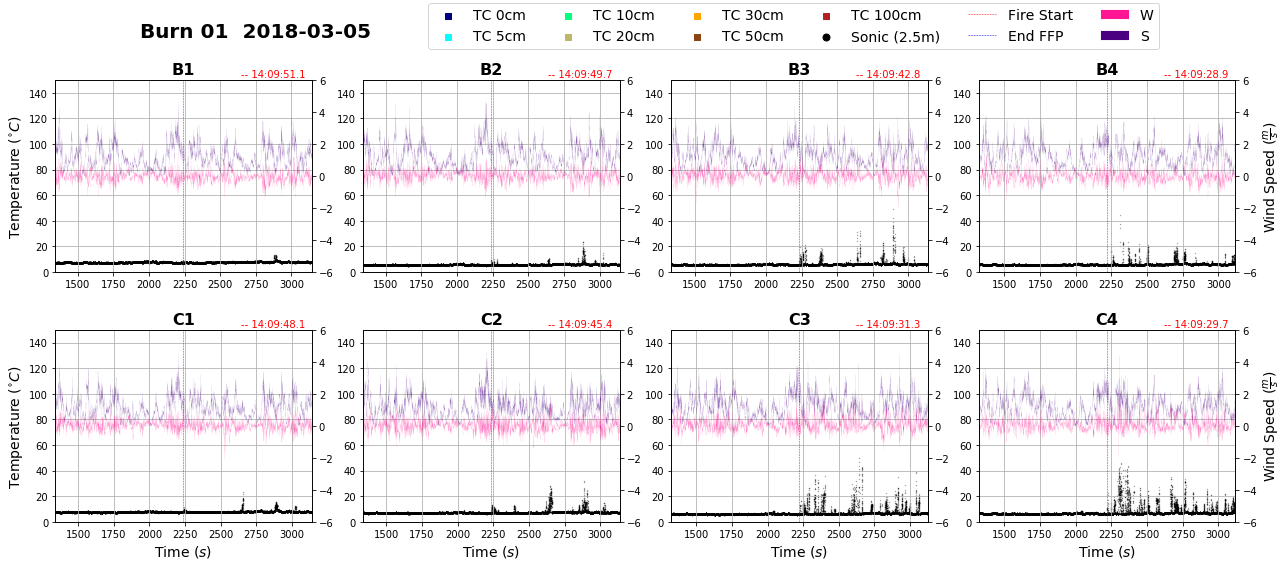

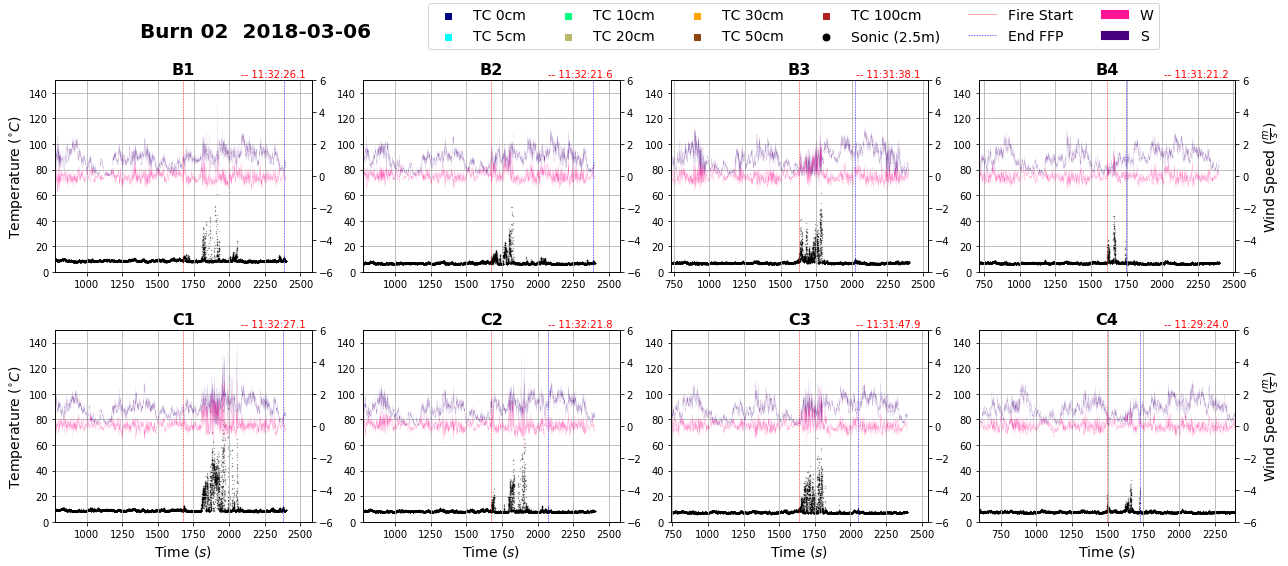

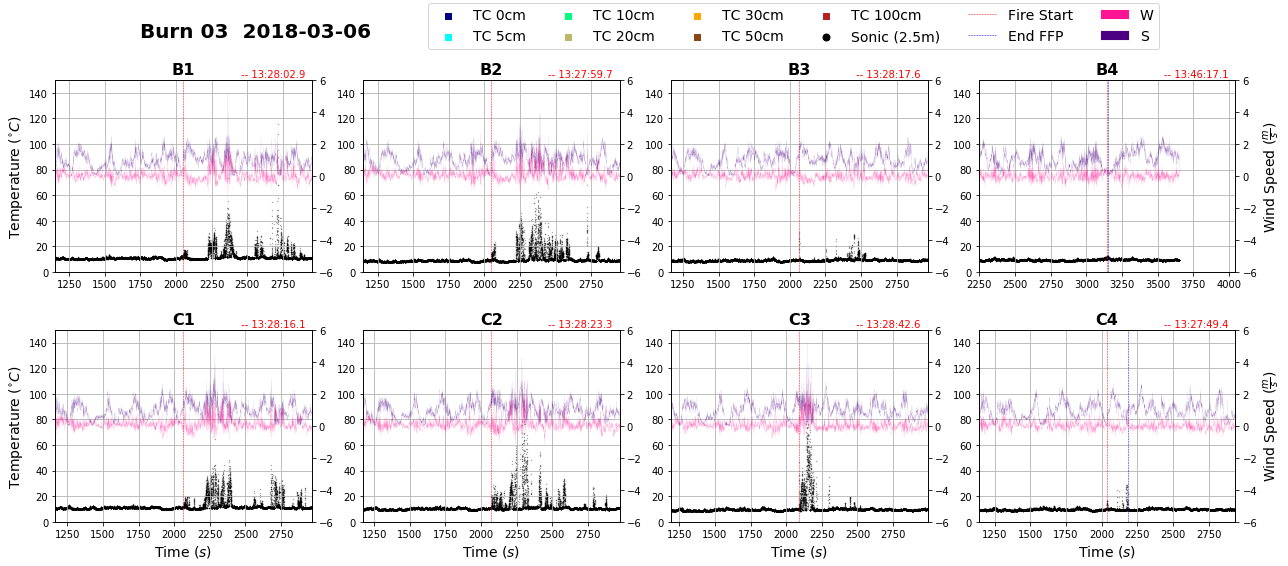

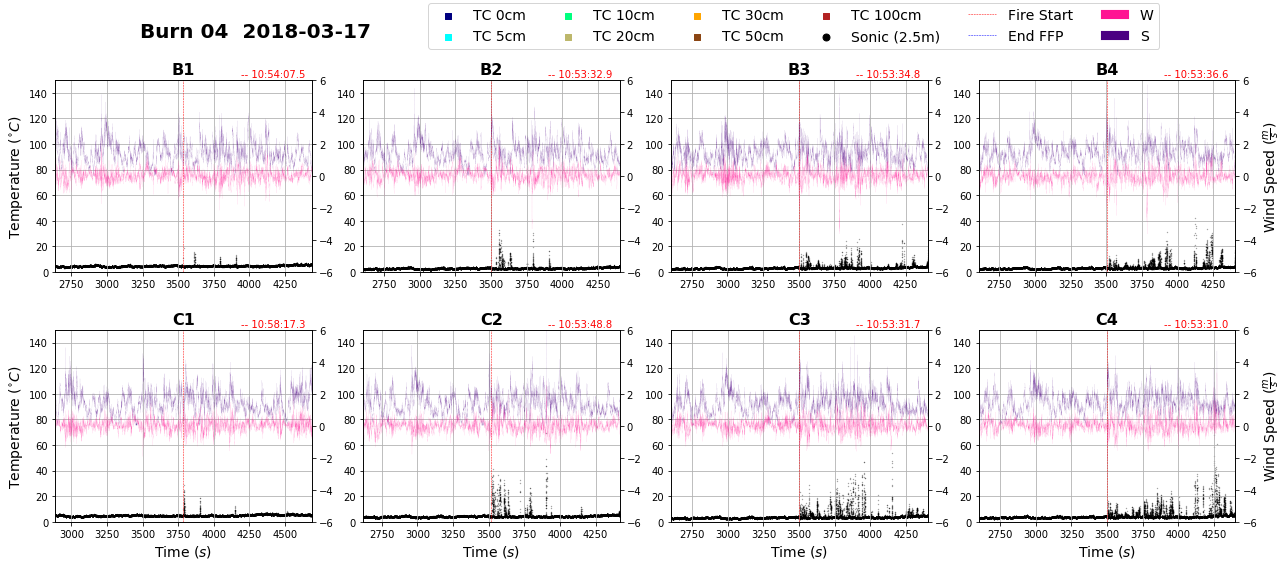

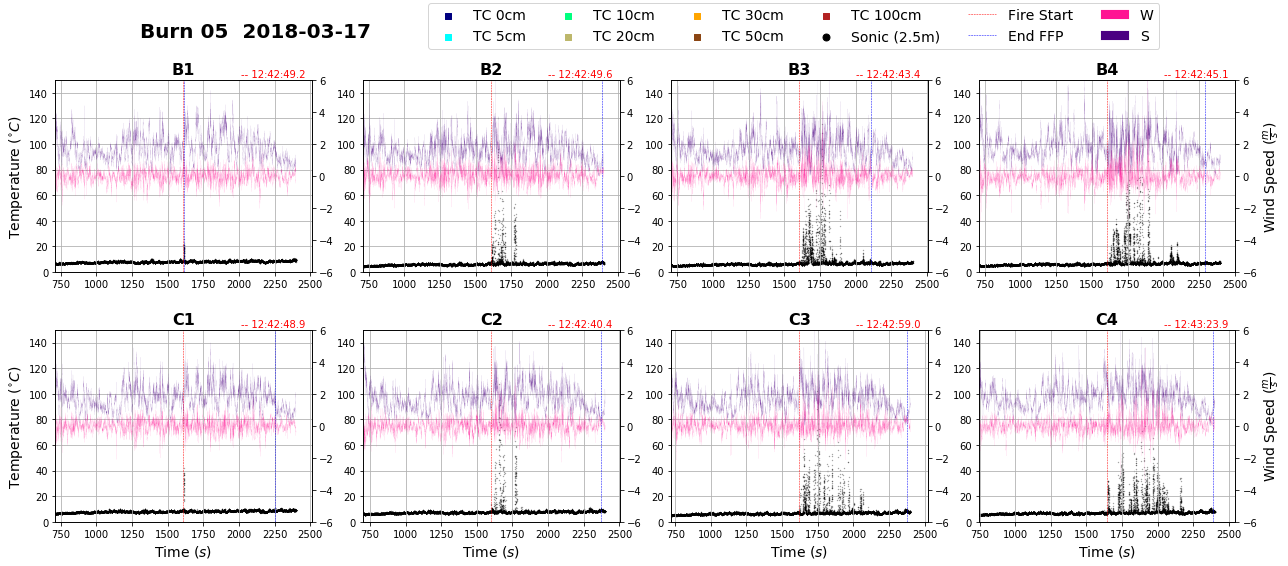

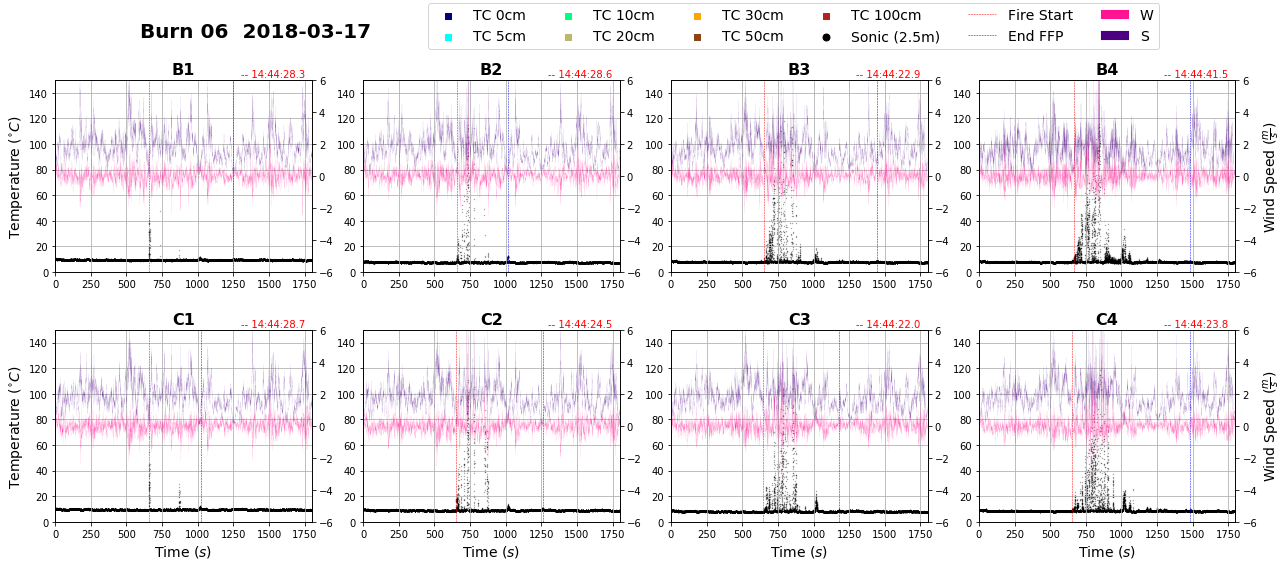

In [124]:
burns = ["01","02","03","04","05","06","07","08","09","11","12","13","18","19","20", \
         "21","22","23","24","25","26","27", "28","29","30","31","32","33","34"]
for brn in burns[:6]:
    plotting_S_W(brn, burn_d[brn][0],burn_d[brn][1], True, 9000)
#plotting_S_W("03",burn_d["03"][0],burn_d["03"][1], True)

In [131]:
def plotting_S_W_2(burn,n,x_fire, y_lim= False, index_time = 9000):
    path = "/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-" #79
    #path = "/Users/joeyp/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-" #W10
    cols= ['TIMESTAMP', 'TC 0cm', 'TC 5cm', 'TC 10cm', 'TC 20cm',\
                  'TC 30cm', 'TC 50cm', 'TC 100cm']

    tc_files = text_finder(path+burn+"/thermal_couples/")
    sonic_files = text_finder(path+burn+"/sonics/")[4:12]
    
    purp_patch = mpatches.Patch(color = "indigo", label = "S", linewidth = .1)
    pink_patch = mpatches.Patch(color="deeppink", label = "W", linewidth = .1)
    
    colors = ["navy","cyan", "springgreen",\
             "darkkhaki", "orange", "saddlebrown", "firebrick"]
    sonic_df_lst, s_fire_lst, e_fire_lst = [], [],[]
    for f in range(8):
        df_son = file_to_df(path+burn+"/sonics/"+sonic_files[f])
        sonic_df_lst.append(df_son)
        s_fire, e_fire = fire(df_son, n, x_fire, index_time)
        s_fire_lst.append(s_fire)
        e_fire_lst.append(e_fire)
        
    plot_cols = cols[1:]
    fig, axs = plt.subplots(nrows=2,ncols=7,figsize=(28,8))

    x, x_2, col_list = 0, 0, [0,2,4,6]
    for col in range(2):
        for row in range(7):
            df_tc=file_to_df(path+burn+"/thermal_couples/"+tc_files[x])
            df_tc.columns = cols
            if row%2 ==0:
                df_s = sonic_df_lst[x_2]
                s_fire, e_fire = s_fire_lst[x_2], e_fire_lst[x_2]
            speed = speed_fun(df_s)
            ### Averaging index
            
            
            #30mins = 18000 15mins = 9000 10mins = 6000 5mins = 3000
            if row%2!= 0:
                if s_fire_lst[x_2]!=0 and s_fire_lst[x_2-1] != 0:
                    s_fire = (s_fire_lst[x_2]+s_fire_lst[x_2-1])/2
                if s_fire_lst[x_2] == 0:
                    s_fire =[x_2-1]
                if s_fire_lst[x_2-1] ==0:
                    s_fire = [x_2]
                
                if e_fire_lst[x_2]!=0 and e_fire_lst[x_2-1] != 0:
                    e_fire_lst[x_2]+e_fire_lst[x_2-1]/2
                if e_fire_lst[x_2] == 0:
                    e_fire =[x_2-1]
                if e_fire_lst[x_2-1] ==0:
                    e_fire = [x_2]
                    
            t_start, t_end = 0,  (len(df_s)-1)
            if s_fire - index_time > 0:
                t_start = int(s_fire - index_time)
            if s_fire + index_time > t_end:
                t_end = int(s_fire + index_time)
                
            ax = axs[ col, row]
            ax.grid()
            x_lst= np.arange(0,len(df_tc)/10,step = .1)
            #print(t_start,t_end)
            for i in range(len(plot_cols)):
                ax.scatter(x_lst[t_start:t_end],df_tc[plot_cols[i]][t_start:t_end], label = plot_cols[i], marker = "s", s = .1, c = colors[i], alpha = .5)
                
            if row%2 == 0:
                ax.scatter(x_lst[t_start:t_end],df_s["T"][t_start:t_end], label ="Sonic (2.5m)", c = "black", marker = "o", s=.1, alpha = .5)
                ax2 = ax.twinx()
                ax2.plot(x_lst[t_start:t_end], speed[t_start:t_end], color = "indigo",linewidth =.05, linestyle = "--")
                ax2.plot(x_lst[t_start:t_end], df_s["W"][t_start:t_end], c="deeppink", linewidth =.05, linestyle = "--")
                ax2.set_ylim(-6,6)
            if row ==6:
                ax2.set_ylabel(r"Wind Speed ($\frac{m}{s}$)", fontsize = 14)
            #if row%2!= 0:
            ax.vlines(s_fire/10,0,600,linestyle = "--",linewidth = .5, label = "Fire Start", color = "r")
            #if row%2 == 0:
            #    ax.vlines(s_fire/10,0,600,linestyle = "--",linewidth = .5, label = "Fire Start", color = "r")
            ax.vlines((e_fire)/10,-10,600,linestyle = "--",linewidth = .5, label = "End FFP", color = "b")
            xttl = int((t_start/10)+(index_time/5)-500)
            print(xttl)
            ax.text(xttl,152, "-- "+df_s["TIMESTAMP"][s_fire][11:21], color = "r")
            ax.set_xlim(t_start/10, (t_start/10)+1800)
            if y_lim == True:
                ax.set_ylim(0,150)
            if y_lim == False:
                ax.set_ylim(0,600)
                
            if row%2 == 0:
                sub_title = str("SC "+sonic_files[x_2][:2]+ " TC " + tc_files[x][:2] )
                ax.set_title(sub_title, fontsize = 16,fontweight = "medium")
                x_2 += 1
            if row%2 != 0:
                ax.set_title("TC "+tc_files[x][:2], fontsize = 16,fontweight = "medium")
                
            if row == 0:
                ax.set_ylabel(r"Temperature ($^{\circ}C$)", fontsize = 14)
            if col == 1:
                ax.set_xlabel(r"Time (${s}$)", fontsize = 14)
            
            x=x+1 #used to change the files
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.25, wspace=0.25, top=.85)#, left = 0.05, right = .95, bottom = .07)
    fig.suptitle("Burn "+burn+"  "+df_tc["TIMESTAMP"][0][:10], fontsize = 22, x= .3, y= .95, fontweight = "bold")
    handles, labels = ax.get_legend_handles_labels()
    leg = fig.legend(list(handles[:10]+ [pink_patch, purp_patch]), list(labels[:10]+[ "W", "S"]), ncol = 6, fontsize = 14, bbox_to_anchor=(.9, .99), framealpha = .8,markerscale = 22 )
    [lh.set_alpha(1) for lh in leg.legendHandles ]
    if y_lim == True:
        fig.savefig("TEST-W-S-TC-Sonic-Temp-150C-Burn-"+burn+"_Grid.png",dpi=450)
    if y_lim == False:
        fig.savefig("TEST-W-S-TC-Sonic-Temp-Burn-"+burn+"_Grid.png",dpi=450)
    plt.show()

/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


2419
2400


TypeError: cannot do label indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [20000.5] of <class 'numpy.float64'>

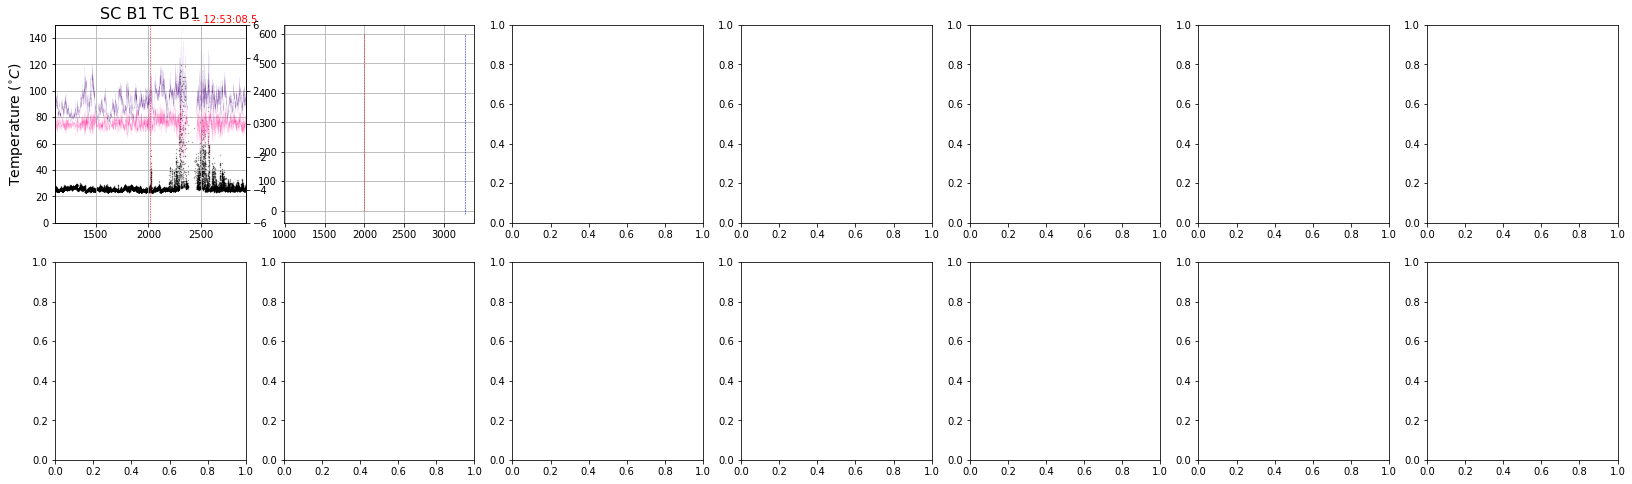

In [132]:
burns = ["01","02","03","04","05","06","07","08","09","11","12","13","18","19","20", \
         "21","22","23","24","25","26","27", "28","29","30","31","32","33","34"]
#for brn in burns[6:]:
#    plotting_S_W_2(brn, burn_d[brn][0], burn_d[brn][1], True)
plotting_S_W_2("08",burn_d["08"][0], burn_d["08"][1],True)

In [40]:
0%2

0